Bradley Holt\
D213: Advanced Data Analytics\
Task 1: Time Series Modeling\
Date: 09 February 2022

# Part I: Research Question
## A1: Question Summarization
What is Telco's forecasted trend for the next fiscal quarter's daily revenue?

## A2: Objectives and Goals of the Data Analysis

The Box-Jenkins approach is used describe the objectives and goals of the data analysis:

1) Identification: This step is used to ensure that the data is appropriate for time-series analysis and, if not, transform the data so that is it. This includes formatting the data and timestamps as necessary, upsampling or downsampling as required, transforming the data so that it is stationary, and identifying ARIMA model orders. 

2) Estimation: ARIMA models are created and fit using the available training data. Metrics such as AIC and BIC are used to identify and select the best available model. 

3) Model Diagnostics: The selected model is diagnosed using the predicted residuals. The residuals are checked to ensure that they are distributed normally and they are uncorrelated.

4) Decision: After evaluating the model and it's error diagnostics a decision is made to use the model or not.

5) Repeat: If the residuals don't meet standards, then the model creation process starts again while rethinking the choices made during the initial model creation. 

6) Production: If the residuals meet standards then prediction forecasts can be made.


# Part II: Method Justification

Assumptions of a time series model: 

1) Stationarity

In order for time series analysis to be conducted properly the data being used must be tranformed to be stationary. Stationarity must meet three criteria:
    - The series has zero trend (upwards or downwards)
    - The data isn't growing or shrinking (constant autocorrelation)
    - The variance of the data is constant. 

2) Autocorrelation

The second assumption, autocorrelation, measures the relationship between a variable's current value and its past values. The output of an autocorrelation calculation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

# Part III: Data Preparation

In [1]:
# Libraries used 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Import teleco_time_series.csv as DataFrame named revenue 
revenue = pd.read_csv("C:/Users/holtb/Data/WGU Datasets/teleco_time_series.csv")

## C1: Line Graph

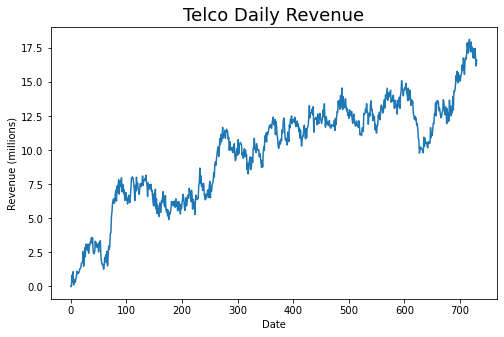

In [3]:
# Plot the line graph of the DataFrame
fig, ax1 = plt.subplots(figsize=(8,5))
revenue['Revenue'].plot(ax=ax1)
plt.title("Telco Daily Revenue", fontsize=18)
plt.xlabel('Date')
plt.ylabel("Revenue (millions)")
plt.show()

## C2: Description of Time Step Formatting

According to the teleco_time_series.csv documentation, the time series contains 731 rows (Days) of information. This is validated by printing both the ```.info()``` method of the DataFrame and calculating the length of the DataFrame. By matching the length of the time series with the documentation and observing the line graph visualization above it can be shown that there are no gaps in the data. 

By printing the ```.head()``` method on the time series, the column ```Day``` is checked for the time step. By evaluating this outcome it is shown that the time step of the data is in days. 

However, since many of the methods used require an DateTime index, the index is set to a DateTime series of 731 daily frequency. Since no actual dates are provided in the data or the data documentation it is assumed that the data is derived from the preivious two years, 2020 and 2021. The ```.head()``` and ```.tail()``` methods are used to confirm the correct starting and ending dates and the ```len()``` method is used to validate the correct number of days.

In [4]:
# Print .info method of DataFrame
print(revenue.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB
None


In [5]:
print(len(revenue))

731


In [6]:
# Print first 5 entries of DataFrame
print(revenue.head())

   Day   Revenue
0    1  0.000000
1    2  0.000793
2    3  0.825542
3    4  0.320332
4    5  1.082554


In [7]:
# Create datetime series range of 731 days starting 2020-01-01
dates = pd.date_range(start='2020', periods=731, freq='D')

In [8]:
# Set index as datetimes created and drop the 'Day' column
revenue = revenue.set_index(dates)
revenue = revenue.drop(columns='Day').asfreq('D')

In [9]:
print(revenue.head())

             Revenue
2020-01-01  0.000000
2020-01-02  0.000793
2020-01-03  0.825542
2020-01-04  0.320332
2020-01-05  1.082554


In [10]:
print(revenue.tail())

              Revenue
2021-12-27  16.931559
2021-12-28  17.490666
2021-12-29  16.803638
2021-12-30  16.194813
2021-12-31  16.620798


In [11]:
print(len(revenue))

731


## C3: Stationarity of the Time Series

The stationary of the data is a requirement to create an accurate model. Stationarity means that the distribution of the data doesn't change over time. For a time series to be stationary it must fulfill three criteria:

1) The series has zero trend
2) The series isn't growing or shrinking
3) The variance of the data is constant (no seasonality)

(Fulton)

There are a few different ways to test for stationarity. The most common is just to look at the line graph visualization of the data. Just by eyeing the line graph plotted above, it is apparent that the data violates at least the first two criteria of stationary data. However, there is a more formal way to test for stationarity, called the Dicky-Fuller test. This statistical test uses the null hypothesis that the time series is non-stationary due to trend. The test returns an array of results, the most important being the first and second positions. The first position is the test statistic. The more negative the number is the higher the likelihood that the series is stationary. The second position is the p-value of the test. This p-value determines if the null hypothesis is accepted or rejected. If the p-value of the test result is below 0.05 (the most common p-value used) the hypothesis that the time series is non-stationary is rejected.

After running the Dickey-Fuller test on the time-series using the ```adfuller()``` method, it returns a test statistic of -1.92 and a p-value of 0.32. Using the results of the test it is determined that the time series is not stationary and therefore needs to be transformed in some way to become stationary. There are a few different ways to transform the data:

- Take the difference
    - ```np.diff(df)```
- Take the log
    - ```np.log(df)```
- Take the square root
    - ```np.sqrt(df)```
- Take the proportional change
    - ```df.shift(1)/df```

The simplest method is often the best selection to transform the data. In this case, taking the difference of the time-series data point was sufficent to transform the data to a stationary time-series. The differenced data is both plotted and tested with the Dickey-Fuller test below. Both the visualization of the plot and the results of the Dickey-Fuller test confirm that the transformed data is now stationary.

Since the ARIMA model development can transform non-stationary to stationary data on its own. The original non-stationary data will be provided and used in model development. However, the data will be transformed to meet specific tasks requirements as needed.

In [12]:
#Perform Dickey-Fuller test on time series
results = adfuller(revenue)
#Print second element of output; the p-value of the test
print('Test Statistic:', results[0])
print('P-value:', results[1])

Test Statistic: -1.924612157310183
P-value: 0.3205728150793967


In [13]:
# Transform the data to stationary data and drop the starting NaN value
revenue_diff = revenue.diff().dropna()

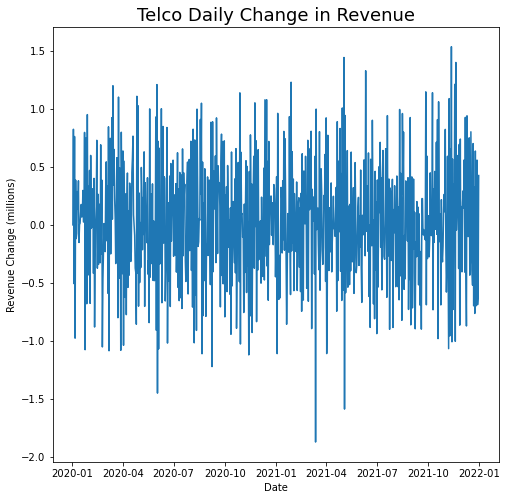

In [14]:
# Plot the differences of each consecutive datapoint in the DataFrame
fig, ax1 = plt.subplots(figsize=(8,8))
plt.plot(revenue_diff)
plt.title("Telco Daily Change in Revenue", fontsize=18)
plt.xlabel('Date')
plt.ylabel("Revenue Change (millions)")
plt.show()

In [15]:
# Perform Dickey-Fuller test on time series
results_diff = adfuller(revenue_diff)
#Print second element of output; the p-value of the test
print('Test Statistic:', results_diff[0])
print('P-value:', results_diff[1])

Test Statistic: -44.874527193876
P-value: 0.0


## C4: Data Preparation Steps

The data preparation steps are already almost complete. The final step is to split the data into training and testing data. Since businesses normally review key performance metrics on a monthly or quarterly basis the data was split using the first six quarters as training and the last two quarters as testing. The data was retained as non-stationary data since the SARIMAX function takes a differencing parameter to make the data stationary.

In [16]:
# Split the data into a train and test set
revenue_train = revenue.loc[:'2021-06']
revenue_test = revenue.loc['2021-07':]

## C5: Copy of Cleaned Datasets

In [17]:
# Export training and testing set DateFrames to Excel
revenue.to_excel("C:/Users/holtb/Data/D213_Advanced_Data_Analytics/revenue.xlsx")
revenue_train.to_excel("C:/Users/holtb/Data/D213_Advanced_Data_Analytics/revenue_train.xlsx")
revenue_test.to_excel("C:/Users/holtb/Data/D213_Advanced_Data_Analytics/revenue_test.xlsx")

# Part IV:  Model Identification and Analysis

## D1: Annotated Findings Report

### Seasonal Component

Seasonality in the data is any regular and predictable patterns in the data (weekly, monthly, weekends, etc.). One way to detect seasonality in the data is to find the differences between each data point and the rolling mean then plot the ACF of the data. Pattern in the lags will be apparent if seasonality exists. By plotting the ACF of the rolling mean differences in the Teleco data (shown below), there shows no evidence that significant seasonality exist in the data.  

In [18]:
# Subtract long rolling average over 15 steps to detrend
revenue_train_detrended = revenue_train - revenue_train.rolling(25).mean()

# Drop NaN values
revenue_train_detrended = revenue_train_detrended.dropna()

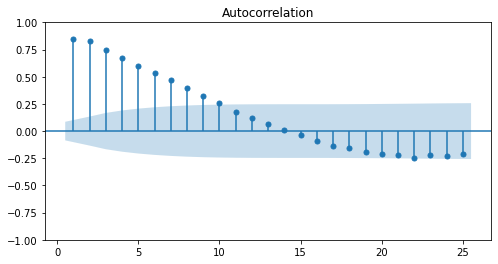

In [19]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))

# Plot ACF of detrended data
plot_acf(revenue_train_detrended, ax=ax, lags=25, zero=False)
plt.show()

### Trend

By observing the original line chart it can be deducted that there is an upward (positive) trend in the data. This is important to note because the trend parameter should be considered when implementing the ARIMA model.


### Autocorrelation Functions (ACF) and Partial Autocorrelation Function (PACF)

The ACF and PACF are important factors when deciding the orders of the ARIMA model. The ARIMA model orders consist of p,d, and q. The p variable is the auto-regressive order and the q variable is the moving average(MA) order. The d variable is the differencing to be conducted on the data to create a stationary data set. This is also known as intergrated modeling and is the 'I' in the ARIMA acronym.

The ACF determines if the model is a AR model and takes into account the direct and indirect effects of the lagged data. When ploting the ACF below we can see that the AR cuts off at two lags.

The PACF determines if the model is a MA model and takes into account only the direct effects of the lagged data. When ploting the PACF below we can see that MA cuts off at one lag.

Because both the p and q orders are identified as non-zero, another method will need to be used to determine the best model to use.

C:\Users\holtb\anaconda3\envs\WGU\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


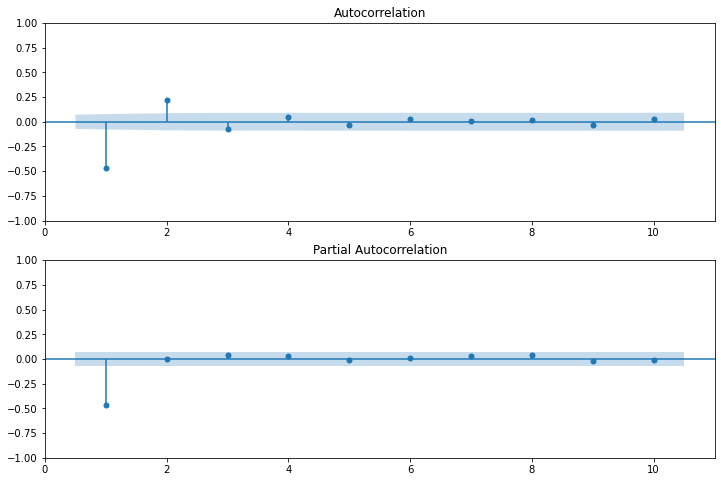

In [20]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
# Plot the ACF of savings on ax1
plot_acf(revenue_diff, lags=10, zero=False, ax=ax1)
# Plot the PACF of savings on ax2
plot_pacf(revenue_diff, lags=10, zero=False, ax=ax2)

plt.show()

### Spectral Density
#### Periodogram (Stationary Data)

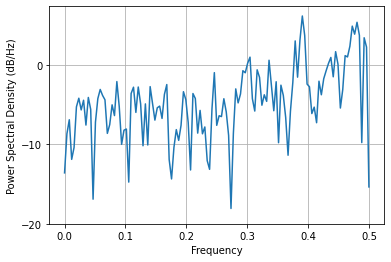

In [21]:
# Converting training set to stationary and dropping NaN value
revenue_train_diff = revenue_train.diff().dropna()
plt.psd(revenue_train_diff['Revenue'], Fs=1)
plt.show()

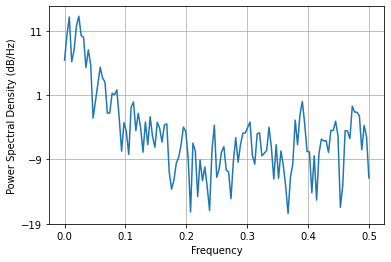

In [22]:
plt.psd(revenue_train_detrended['Revenue'], Fs=1)
plt.show()

#### Spectrogram

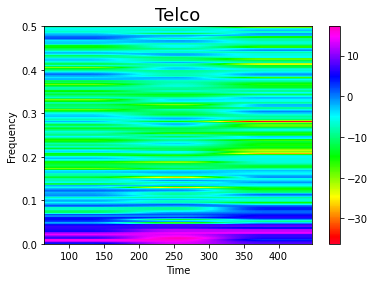

In [23]:
plt.specgram(revenue_train_detrended['Revenue'], NFFT=256, Fs=1, cmap='gist_rainbow')
plt.colorbar()
plt.title("Telco", fontsize=18)
plt.xlabel('Time')
plt.ylabel("Frequency")

plt.show()

### Decomposed Time Series / Lack of Trends

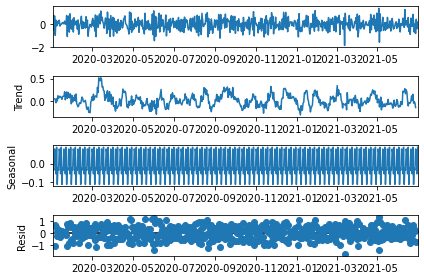

In [24]:
# Decomposing the detrended data
decomposition = seasonal_decompose(revenue_train_diff)
decomposition.plot()
plt.show()

## D2a: ARIMA Model

Taking the information we gathered in the previous sections, multiple iterations of models are ran with for loops setting different parameters. The AR(p), MA(q) and trend ranges are set as looped parameters. According to the ACF and PACF ran above, the highest significant AR order could be two and the highest MA order could be one. Since the data being used for the model is non-stationary and it has already been tested that a differencing of one qualifies the data as stationary the intergration order is set to one. Additionally, it is known that the data consist of an upward trend so all parameters of trend are set into a list to include the no trend parameter. This list will be included in the looping function. 

Once each model is ran the AIC and BIC are appended into a list to review once all models have been ran. The model with the lowest AIC is selected for use. Furthur discussion of the AIC and BIC for model evaluation can be found in Part V.

In [25]:
order_aic_bic =[]
# Loop over AR order from 0-2
list = ['c', 't', 'ct', None]
for p in range(2):
    # Loop over MA order from 0-2
    for q in range(1):
        #Loop list of trends
        for i in list:
            try:
                #fit model
                model = SARIMAX (revenue_train, order = (p,1,q), trend = i)
                results = model.fit()
                #Add order and scores to list
                order_aic_bic.append((p, q, i, results.aic, results.bic))
                
            except:
                #Add order and None scores to list
                order_aic_bic.append((p, q, i, None, None))

C:\Users\holtb\anaconda3\envs\WGU\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','i','aic','bic'])

In [27]:
# Sort by AIC
print(order_df.sort_values('aic'))

   p  q     i         aic         bic
4  1  0     c  727.227205  740.135061
7  1  0  None  727.981687  736.586925
6  1  0    ct  728.009500  745.219976
5  1  0     t  729.193092  742.100948
3  0  0  None  858.577871  862.880490
0  0  0     c  859.564509  868.169747
1  0  0     t  860.280702  868.885940
2  0  0    ct  861.135364  874.043221


In [28]:
# Create ARIMA(1,1,0) model
model = SARIMAX(revenue_train, order=(1,1,0), trend='c')

# Fit ARIMA model
train_results = model.fit()

# Print summary
print(train_results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  547
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -360.614
Date:                Wed, 09 Feb 2022   AIC                            727.227
Time:                        22:11:39   BIC                            740.135
Sample:                    01-01-2020   HQIC                           732.273
                         - 06-30-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0333      0.020      1.653      0.098      -0.006       0.073
ar.L1         -0.4666      0.037    -12.560      0.000      -0.539      -0.394
sigma2         0.2193      0.014     15.680      0.0

In [29]:
train_one_step_forecast = train_results.get_prediction(start='2021-07-01', end='2021-12-31')

In [30]:
train_confidence_intervals = train_one_step_forecast.conf_int()
train_confidence_intervals

,lower Revenue,upper Revenue
2021-07-01,11.488494,13.324079
2021-07-02,11.427009,13.507407
2021-07-03,11.224233,13.720025
2021-07-04,11.120201,13.886158
2021-07-05,10.998303,14.045774
...,...,...
2021-12-27,8.085035,24.919661
2021-12-28,8.084542,24.965630
2021-12-29,8.084112,25.011535
2021-12-30,8.083745,25.057377


In [31]:
#Conduct a forcast using the 
train_forecast = train_results.get_forecast(steps=190).predicted_mean
print(train_forecast)

2021-07-01    12.406286
2021-07-02    12.467208
2021-07-03    12.472129
2021-07-04    12.503180
2021-07-05    12.522039
                ...    
2022-01-02    16.638774
2022-01-03    16.661511
2022-01-04    16.684249
2022-01-05    16.706986
2022-01-06    16.729724
Freq: D, Name: predicted_mean, Length: 190, dtype: float64


## D2b: Final ARIMA Model
The final model is ran on the entire data set for forecasting. The forecasting is then conducted.

In [32]:
# Create Final ARIMA(1,1,0) model
model = SARIMAX(revenue, order=(1,1,0), trend='c')
# Fit ARIMA model
results = model.fit()
# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  731
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -488.561
Date:                Wed, 09 Feb 2022   AIC                            983.122
Time:                        22:11:39   BIC                            996.901
Sample:                    01-01-2020   HQIC                           988.438
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0332      0.018      1.895      0.058      -0.001       0.068
ar.L1         -0.4692      0.033    -14.296      0.000      -0.534      -0.405
sigma2         0.2232      0.013     17.801      0.0

## D3: Forecast Output

In [33]:
# Get next quarter's forecast
forecast = results.get_forecast(steps=90).predicted_mean
forecast = pd.DataFrame(forecast)
forecast.index.names = ['Date']
print(forecast.head(5))
print(forecast.tail(5))

            predicted_mean
Date                      
2022-01-01       16.454117
2022-01-02       16.565530
2022-01-03       16.546453
2022-01-04       16.588606
2022-01-05       16.602028
            predicted_mean
Date                      
2022-03-27       18.435387
2022-03-28       18.457985
2022-03-29       18.480583
2022-03-30       18.503181
2022-03-31       18.525779


In [34]:
# Generate predictions
final_one_step_forecast = results.get_prediction(start='2022-01-01', end='2022-03-31')

In [35]:
# Get confidence intervals of predictions
confidence_intervals = final_one_step_forecast.conf_int()
confidence_intervals

,lower Revenue,upper Revenue
2022-01-01,15.528164,17.380070
2022-01-02,15.517229,17.613830
2022-01-03,15.288505,17.804401
2022-01-04,15.195031,17.982180
2022-01-05,15.066607,18.137449
...,...,...
2022-03-27,12.559643,24.311131
2022-03-28,12.548539,24.367432
2022-03-29,12.537625,24.423541
2022-03-30,12.526899,24.479463


# Part V: Data Summary and Implications

## E1: Data Analysis Results

### ARIMA Model Selection

The final ARIMA model was selected based off the lowest AIC score returned from the created list in Part D2a. This metric assists in determining what models give better predictions and helps prevents overfitting by penalizing for more parameters. Before creating the model, the model orders were compared with the PACF and ACF that were plotted prior to ensure that both results make sense. Alternatively, if a model was required that fits the data best, then the lowest BIC model would have been selected for use.   

### Prediction Interval of Forcast
The prediction interval for the forecast remained at the daily level. This was decided as daily trends were requested in the originating question. However, if weekly or monthly predictions were requested, this could be easily accomplished by upscaling the data. This would only require aggregating the data into the requested time series for analysis.  

### Forecast Length Justification
Since many organizations use quarterly metrics to measure key-performance indexes, a fiscal quarter length (90 days) forecast was created. 


### Model Evaluation Procedure and Error Metric
Evaluation of the model consisted of observation of the residual metrics from the model. The the model summary the Prob(Q) was 0.96, the p-value for a null hypothesis that the residuals are uncorrelated since the result is not below 0.05 the null hypothesis is accepted. The Prob(JB) was 0.36 and is the p-value for a null hypothesis that the residuals are normal. Again, because the p-value is above 0.05 the null hypothesis is accepted. 

The residuals of the predications are assigned to a variable and the mean absolute error of the residuals is calculated which returned as 0.379. This can be used to evaluate other model results if needed. 

The final evaluation procedure returns the ```plot.diagnostics``` of the model residuals. For this portion the 4 plots are evaluated and meet all expected criteria:

1) Standardized residual plot - no obvious structures are found in the chart.
2) Histogram with Estimated Density - orange line (KDE) is relatively matches the green line (normal distribution)
3) Normal Q-Q - All points lie on or about the line with the exception of a few outlier endpoints. 
4) Correlogram - No lags greater than zero are significant


In [36]:
# Assign residuals to variable
residuals = results.resid
print(residuals)

2020-01-01   -0.022598
2020-01-02   -0.021805
2020-01-03    0.791919
2020-01-04   -0.151418
2020-01-05    0.491963
                ...   
2021-12-27   -0.190336
2021-12-28    0.605806
2021-12-29   -0.457882
2021-12-30   -0.964397
2021-12-31    0.107108
Freq: D, Length: 731, dtype: float64


In [37]:
#Calculate MSE of residuals
mae = np.mean(np.abs(residuals))
print(mae)

0.37965021164744234


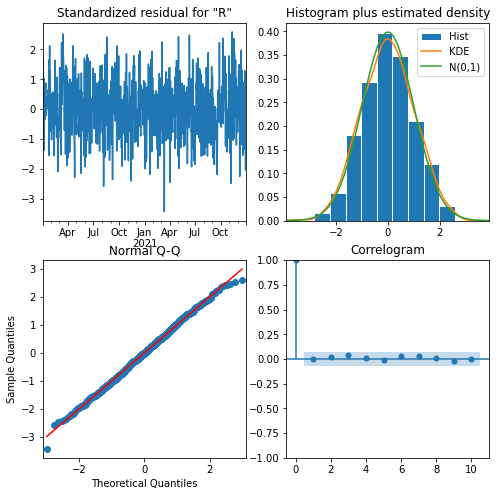

In [38]:
# Create the 4 diagnostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()


## E2: Visualization of Forecast / Test Set

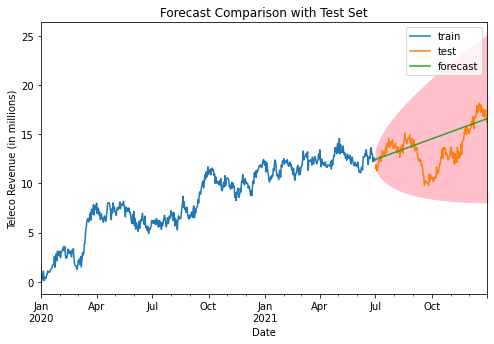

In [57]:
# Create an axis
fig, ax = plt.subplots(figsize=(8,5))
mylabels = ['train','test','forecast']

# Plot the train and test sets on the axis ax
revenue_train.plot(ax=ax)
revenue_test.plot(ax=ax)
plt.plot(train_forecast)
ax.legend(labels=mylabels)
plt.xlabel('Date')
plt.ylabel('Teleco Revenue (in millions)')
plt.title('Forecast Comparison with Test Set')


plt.fill_between(train_confidence_intervals.index, train_confidence_intervals['lower Revenue'], train_confidence_intervals['upper Revenue'], color='pink')

plt.show()

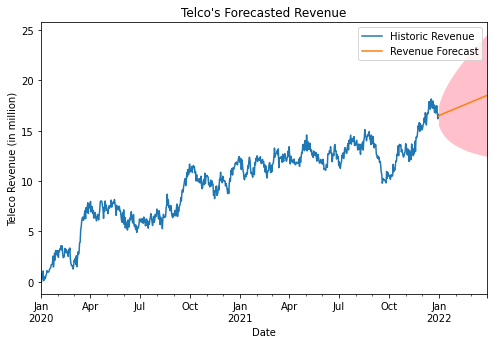

In [55]:
# Create an axis
fig2, ax = plt.subplots(figsize=(8,5))
mylabels = ['Historic Revenue','Revenue Forecast']

# Plot the train and test sets on the axis ax
revenue.plot(ax=ax)
forecast.plot(ax=ax)
ax.legend(labels=mylabels)
plt.title('Telco\'s Forecasted Revenue')
plt.xlabel('Date')
plt.ylabel('Teleco Revenue (in millions)')

plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'], confidence_intervals['upper Revenue'], color='pink')

plt.show()

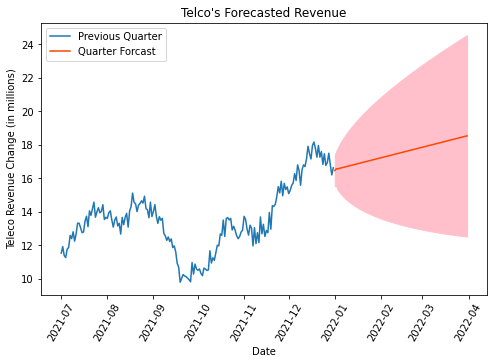

In [58]:
fig3, ax = plt.subplots(figsize=(8,5))

plt.plot(revenue_test.index, 
         revenue_test, 
         label = 'Previous Quarter')
plt.plot(forecast.index,
         forecast,
         color='orangered',
         label='Quarter Forcast')

plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'], confidence_intervals['upper Revenue'], color='pink')

plt.title('Telco\'s Forecasted Revenue')
plt.xlabel('Date')
plt.xticks(rotation = 60)
plt.ylabel('Teleco Revenue Change (in millions)')
plt.legend(loc = 'upper left')

plt.show()

## E3: Recommended Course of Action

While the forecast for daily revenue does trend upward, the large confidence interval shaded in pink leave too much room to expect an increase in revenue. The maximum for the confidence interval lies around 25 (an increase of about 8 million) and the minimum lies at about 13 (a decrease of about 4). The recommended course of action for Telco Communication is to use the available forecast to plan for best case and worst case scenarios for the upcoming quarter. 

# Part VI: Reporting

## F: Create Report
Provided

## G: Third-Party Code

Fulton, J. "ARIMA Models in Python" [MOOC]. Datacamp. https://app.datacamp.com/learn/courses/arima-models-in-python

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020). DOI: 0.1038/s41586-020-2649-2. (Publisher link).

J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007.

Python Software Foundation. Python Language Reference, version 3.7. Available at http://www.python.org

Seabold, S., & Perktold, J. (2010). statsmodels: Econometric and statistical modeling with python. In 9th Python in Science Conference.

## H: In-text Citations

Fulton, J. "ARIMA Models in Python" [MOOC]. Datacamp. https://app.datacamp.com/learn/courses/arima-models-in-python